<a href="https://colab.research.google.com/github/happyemanaloto/Project2-G2/blob/main/Project2_G2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
class_names = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']

# One-hot encode labels
y_train_cat = tf.keras.utils.to_categorical(y_train, 10)
y_test_cat = tf.keras.utils.to_categorical(y_test, 10)

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 13s 0us/step


In [3]:
IMG_SIZE = 160
BATCH_SIZE = 32

def preprocess(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

# Build datasets
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train_cat))
train_ds = train_ds.map(preprocess).shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test_cat))
val_ds = val_ds.map(preprocess).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

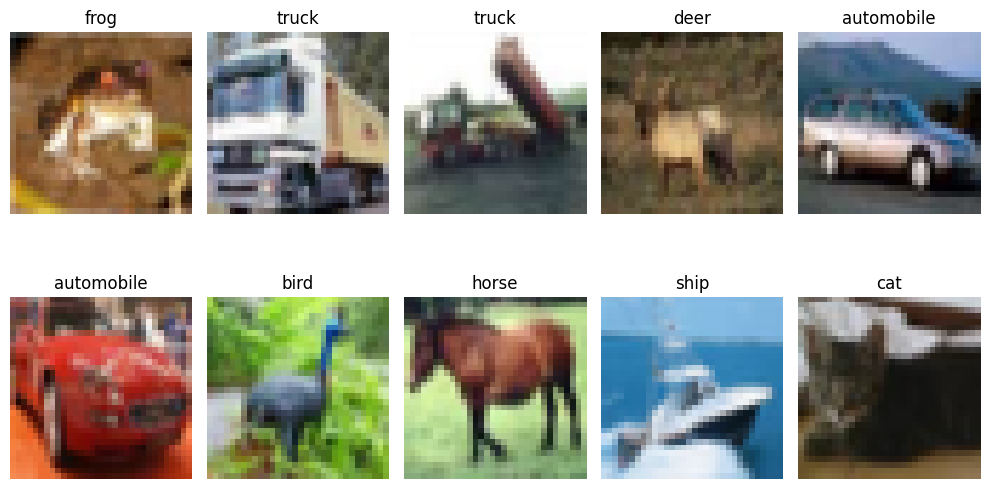

In [4]:
plt.figure(figsize=(10, 6))
for i in range(10):
    img = x_train[i]
    label = class_names[y_train[i][0]]
    plt.subplot(2, 5, i+1)
    plt.imshow(img)
    plt.title(label)
    plt.axis("off")
plt.tight_layout()
plt.show()

In [5]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout

base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
base_model.trainable = False  # freeze base layers

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [6]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(10, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

In [7]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)]
)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 160, 160,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 80, 80,    │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 80, 80,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 80, 80,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 80, 80,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 80, 80,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 80, 80,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 80, 80,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 80, 80,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 81, 81,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 40, 40,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 40, 40,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 40, 40,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 40, 40,    │      2,304 │ block_1_depthwis

 Total params: 2,423,242 (9.24 MB)

 Trainable params: 165,258 (645.54 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 58s 29ms/step - accuracy: 0.6922 - loss: 0.9088 - val_accuracy: 0.7909 - val_loss: 0.5870
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 36s 23ms/step - accuracy: 0.7984 - loss: 0.5884 - val_accuracy: 0.8178 - val_loss: 0.5280
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 37s 23ms/step - accuracy: 0.8123 - loss: 0.5395 - val_accuracy: 0.8219 - val_loss: 0.5183
Epoch 4/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 35s 22ms/step - accuracy: 0.8204 - loss: 0.5086 - val_accuracy: 0.8251 - val_loss: 0.5196
Epoch 5/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 35s 22ms/step - accuracy: 0.8315 - loss: 0.4815 - val_accuracy: 0.8258 - val_loss: 0.5074
Epoch 6/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 41s 22ms/step - accuracy: 0.8363 - loss: 0.4586 - val_accuracy: 0.8277 - val_loss: 0.5159
Epoch 7/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 42s 23ms/step - accuracy: 0.8468 - loss: 0.4387 - val_accuracy: 0.8264 - val_loss: 0.5267
Epoch 8/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 39s 22ms/step - accuracy: 0.8503 -

In [8]:
loss, acc = model.evaluate(val_ds)
print(f"Test Accuracy: {acc:.4f}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.8220 - loss: 0.5211
Test Accuracy: 0.8258


313/313 ━━━━━━━━━━━━━━━━━━━━ 12s 27ms/step
              precision    recall  f1-score   support

    airplane       0.83      0.84      0.84      1000
  automobile       0.94      0.88      0.91      1000
        bird       0.78      0.78      0.78      1000
         cat       0.71      0.68      0.70      1000
        deer       0.82      0.72      0.77      1000
         dog       0.77      0.77      0.77      1000
        frog       0.89      0.85      0.87      1000
       horse       0.77      0.91      0.83      1000
        ship       0.87      0.90      0.89      1000
       truck       0.88      0.92      0.90      1000

    accuracy                           0.83     10000
   macro avg       0.83      0.83      0.83     10000
weighted avg       0.83      0.83      0.83     10000



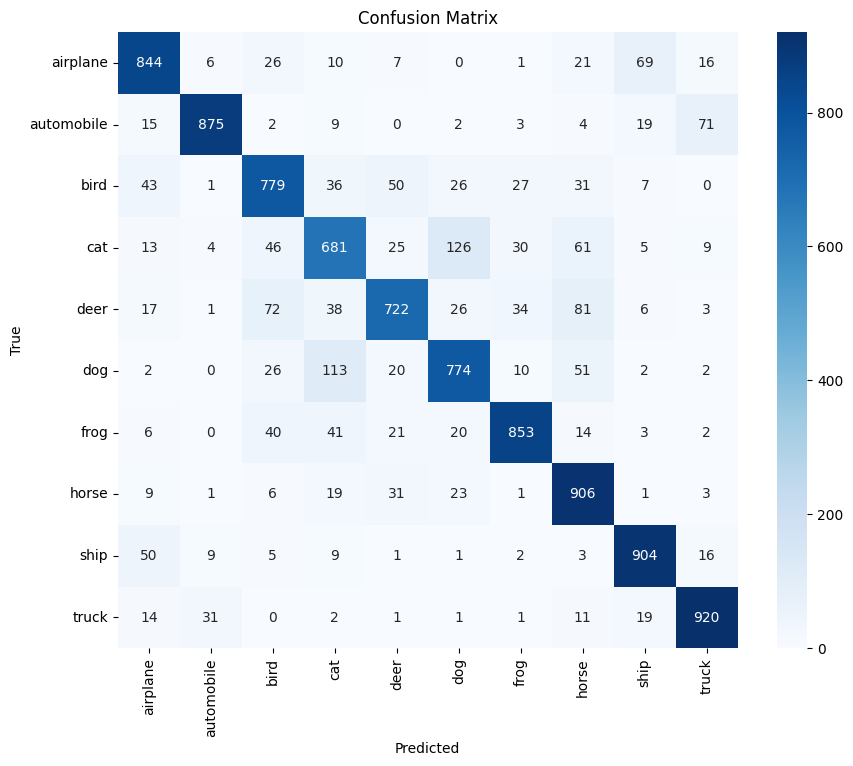

In [9]:
# Predict
y_pred_probs = model.predict(val_ds)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test_cat, axis=1)

# Report
print(classification_report(y_true, y_pred, target_names=class_names))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


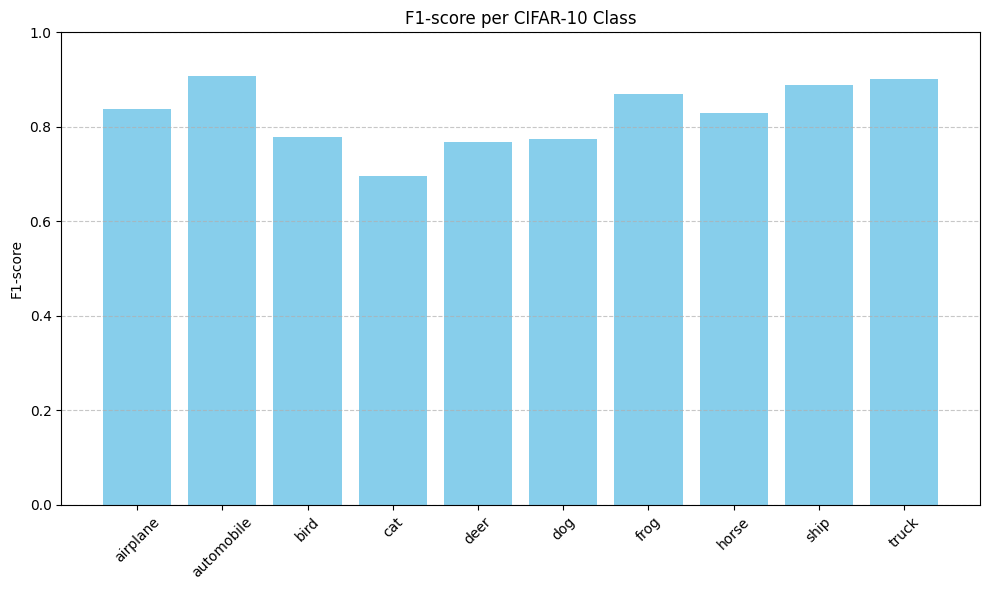

In [10]:
# Parse classification report into dict
report = classification_report(y_true, y_pred, target_names=[
    'airplane', 'automobile', 'bird', 'cat', 'deer',
    'dog', 'frog', 'horse', 'ship', 'truck'], output_dict=True)

# Extract F1-scores
classes = list(report.keys())[:10]
f1_scores = [report[label]['f1-score'] for label in classes]

# Plot bar chart
plt.figure(figsize=(10, 6))
plt.bar(classes, f1_scores, color='skyblue')
plt.ylabel("F1-score")
plt.title("F1-score per CIFAR-10 Class")
plt.ylim(0, 1.0)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [11]:
model.save('cifar10_transfer_model.keras')

In [12]:
# Unfreeze from layer 100 onwards (out of ~154)
UNFREEZE_FROM = 100

# Unfreeze the base model
base_model.trainable = True

# Freeze all layers before `UNFREEZE_FROM`
for i, layer in enumerate(base_model.layers):
    layer.trainable = i >= UNFREEZE_FROM


In [13]:
from tensorflow.keras.optimizers import Adam

model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [14]:
history_finetune = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)
    ]
)

Epoch 1/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 87s 41ms/step - accuracy: 0.7235 - loss: 0.8976 - val_accuracy: 0.8519 - val_loss: 0.4579
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 50s 32ms/step - accuracy: 0.8342 - loss: 0.4980 - val_accuracy: 0.8651 - val_loss: 0.4162
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 82s 32ms/step - accuracy: 0.8630 - loss: 0.4093 - val_accuracy: 0.8764 - val_loss: 0.3840
Epoch 4/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 49s 31ms/step - accuracy: 0.8805 - loss: 0.3448 - val_accuracy: 0.8820 - val_loss: 0.3646
Epoch 5/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 50s 32ms/step - accuracy: 0.8981 - loss: 0.2947 - val_accuracy: 0.8850 - val_loss: 0.3545
Epoch 6/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 50s 32ms/step - accuracy: 0.9092 - loss: 0.2578 - val_accuracy: 0.8895 - val_loss: 0.3485
Epoch 7/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 50s 32ms/step - accuracy: 0.9237 - loss: 0.2247 - val_accuracy: 0.8948 - val_loss: 0.3409
Epoch 8/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 82s 31ms/step - accuracy: 0.9341 -

In [15]:
loss, acc = model.evaluate(val_ds)
print(f"Test Accuracy: {acc:.4f}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.8936 - loss: 0.3443
Test Accuracy: 0.8948


313/313 ━━━━━━━━━━━━━━━━━━━━ 11s 27ms/step
              precision    recall  f1-score   support

    airplane       0.90      0.91      0.90      1000
  automobile       0.96      0.95      0.95      1000
        bird       0.89      0.86      0.87      1000
         cat       0.80      0.79      0.79      1000
        deer       0.86      0.88      0.87      1000
         dog       0.84      0.85      0.85      1000
        frog       0.92      0.92      0.92      1000
       horse       0.92      0.91      0.92      1000
        ship       0.93      0.95      0.94      1000
       truck       0.94      0.94      0.94      1000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



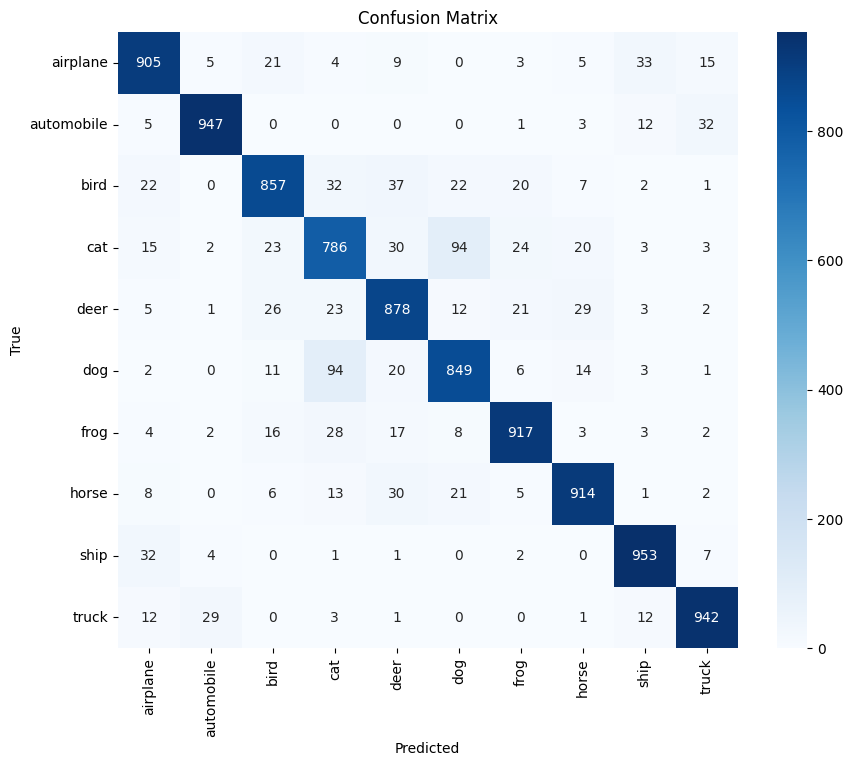

In [16]:
# Predict
y_pred_probs = model.predict(val_ds)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test_cat, axis=1)

# Report
print(classification_report(y_true, y_pred, target_names=class_names))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

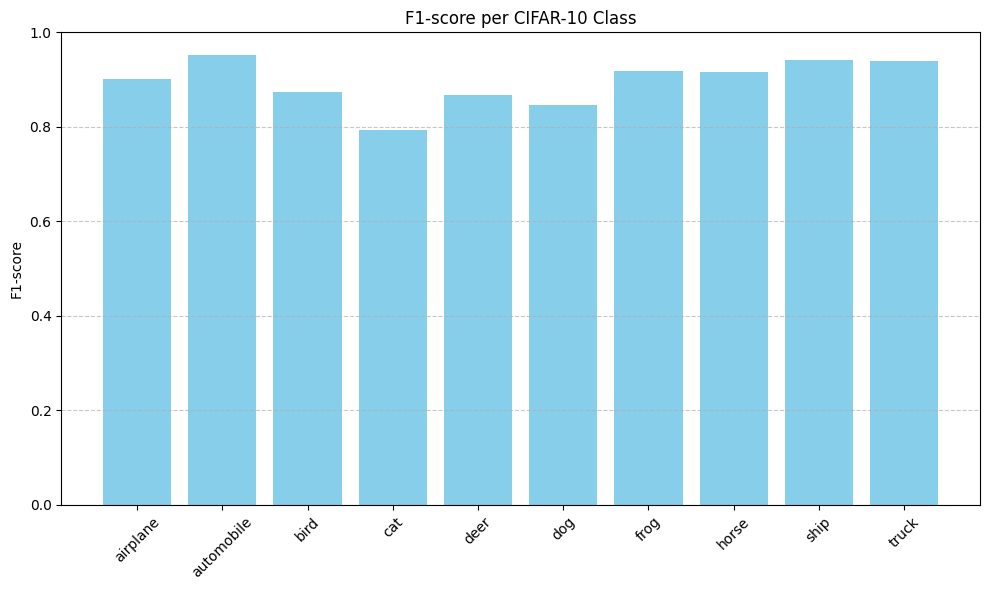

In [17]:
# Parse classification report into dict
report = classification_report(y_true, y_pred, target_names=[
    'airplane', 'automobile', 'bird', 'cat', 'deer',
    'dog', 'frog', 'horse', 'ship', 'truck'], output_dict=True)

# Extract F1-scores
classes = list(report.keys())[:10]
f1_scores = [report[label]['f1-score'] for label in classes]

# Plot bar chart
plt.figure(figsize=(10, 6))
plt.bar(classes, f1_scores, color='skyblue')
plt.ylabel("F1-score")
plt.title("F1-score per CIFAR-10 Class")
plt.ylim(0, 1.0)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [18]:
model.save('cifar10_transfer_model.keras')

In [19]:
pip install --upgrade gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.9/46.9 MB 21.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.6/322.6 kB 26.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 114.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 6.3 MB/s eta 0:00:00


In [20]:
import gradio as gr
import tensorflow as tf
import numpy as np
from PIL import Image

# Load the model
model = tf.keras.models.load_model("cifar10_transfer_model.keras")

# CIFAR-10 class names
class_names = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']

IMG_SIZE = 160  # or 224 if you used VGG16

def predict(image):
    # Resize and preprocess
    image = image.resize((IMG_SIZE, IMG_SIZE))
    img_array = np.array(image) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Predict
    preds = model.predict(img_array)[0]
    result = {class_names[i]: float(preds[i]) for i in range(10)}
    return result

# Gradio Interface
app = gr.Interface(
    fn=predict,
    inputs=gr.Image(type="pil"),
    outputs=gr.Label(num_top_classes=3),
    title="CIFAR-10 Image Classifier",
    description="Upload a CIFAR-like image and get predictions with class probabilities."
)

# Launch the app
app.launch()


It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://22e28149b52e879706.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
